# Analyzing Factors Leading to Success of Spotify Artists
### Author: Rao Abdul Hannan

## Introduction

Spotify is the leading digital music streaming service that offers users acess to millions of songs, podcasts, and playlists from a diverse range of genres and artists. This report presents a comprehensive analysis of Spotify artists, focusing on various metrics that define their success and popularity in the digital music landscape. By examining streams, tracks reaching significant milestones-such as 100 million and 1 billion streams-we aim to establish a clear ranking system that highlights the most prominent artists. Additionally, clustering techniques will be employed to identify similarities among artists based on their streaming patterns and track characteristics, providing insights into the dynamics of the music industry. This analysis not only enhances our understanding of artist performance on Spotify but also contributes to the broader discourse on music consumption trends in the streaming era. 

In [44]:
# Loading required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [45]:
# Loading the data
spotify_artist = pd.read_csv("/Users/raoabdulhannan/Documents/Projects/spotify/spotify_artist.csv",
                             thousands=',', encoding='utf-8',
                             names=['number', 'artist_name', 'lead_streams', 'feats', 'tracks', 'one_bil', 'hund_mil', 'last_updt'],
                             header=0)

In [46]:
styled_df = spotify_artist.head().style.set_table_attributes('class="dataframe"').set_caption("Spotify Artists Dataset")
styled_df

,number,artist_name,lead_streams,feats,tracks,one_bil,hund_mil,last_updt
0,1,Drake,"50,162,292,808","19,246,513,666",262,6,130,19.09.22
1,2,Bad Bunny,"44,369,032,140","5,391,990,975",163,5,118,20.09.22
2,3,Ed Sheeran,"38,153,682,361","2,791,278,201",240,10,62,19.09.22
3,4,The Weeknd,"34,767,779,741","4,288,903,657",186,8,72,19.09.22
4,5,Taylor Swift,"32,596,728,109","424,053,296",323,1,96,20.09.22


In [47]:
# Verifying the data is loaded correctly
print(spotify_artist.head())

   number   artist_name    lead_streams           feats tracks one_bil  \
0       1         Drake  50,162,292,808  19,246,513,666    262       6   
1       2     Bad Bunny  44,369,032,140   5,391,990,975    163       5   
2       3    Ed Sheeran  38,153,682,361   2,791,278,201    240      10   
3       4    The Weeknd  34,767,779,741   4,288,903,657    186       8   
4       5  Taylor Swift  32,596,728,109     424,053,296    323       1   

  hund_mil last_updt  
0      130  19.09.22  
1      118  20.09.22  
2       62  19.09.22  
3       72  19.09.22  
4       96  20.09.22  


In [48]:
# Cleaning the data
spotify_artist = spotify_artist[spotify_artist['last_updt'] != 'Update']

In [49]:
# Removing the commas from numeric columns
def comma_to_float(col):
    return float(col.replace(',', '')) if isinstance(col, str) else col


numeric_cols = ['lead_streams', 'feats', 'tracks', 'one_bil', 'hund_mil']
for col in numeric_cols:
    spotify_artist[col] = spotify_artist[col].apply(comma_to_float)

In [50]:
# Converting the last column to date format
spotify_artist['last_updt'] = pd.to_datetime(spotify_artist['last_updt'], format='%d.%m.%y')

In [51]:
# Defining new variables for analysis
spotify_artist['avg_streams'] = spotify_artist['lead_streams'] / spotify_artist['tracks']
spotify_artist['total_streams'] = spotify_artist['lead_streams'] + spotify_artist['feats']
spotify_artist['milestone_tracks'] = spotify_artist['one_bil'] + spotify_artist['hund_mil']
spotify_artist['feature_ratio'] = spotify_artist['feats'] / spotify_artist['lead_streams']

In [52]:
top_artists_total = spotify_artist.sort_values('total_streams', ascending=False).head(20)
top_artists_lead = spotify_artist.sort_values('lead_streams', ascending=False).head(20)
top_featured_ratio = spotify_artist.sort_values('feature_ratio', ascending=False).head(20)

In [53]:
pio.templates.default = 'plotly_white'
pio.templates['plotly_white'].layout.colorway = pc.qualitative.Set2

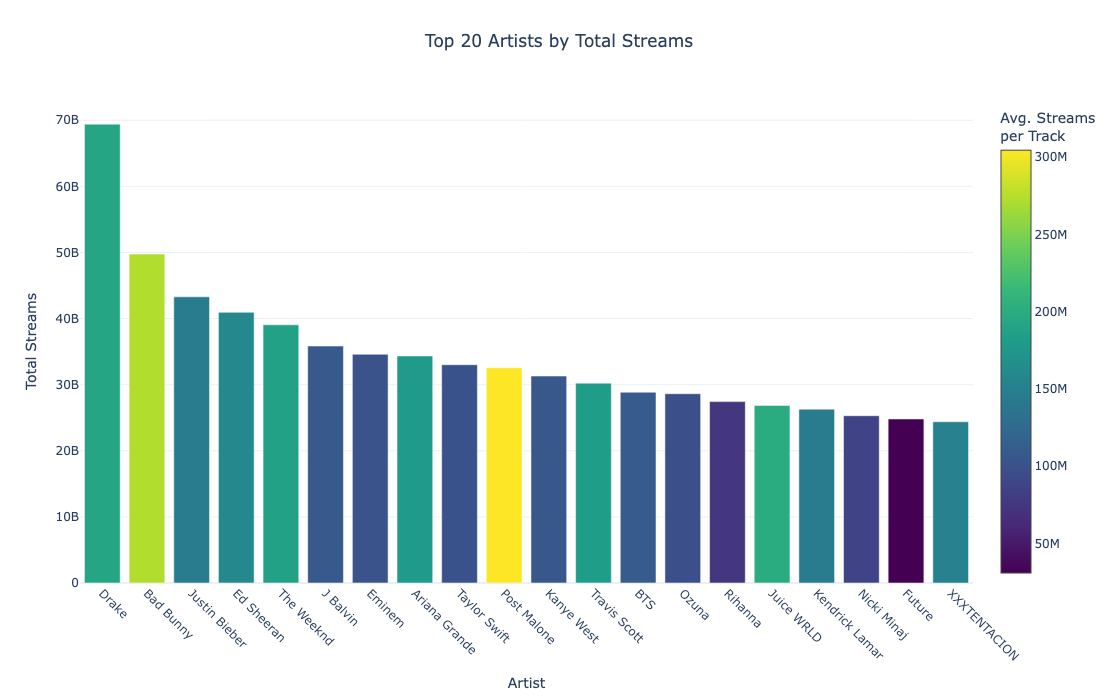

In [54]:
def top_artists_visualization(df, n=20):
    
    # Calculate total streams and feature ratio
    df['total_streams'] = df['lead_streams'] + df['feats']
    df['feature_ratio'] = df['feats'] / df['lead_streams']
    
    top_artists = df.nlargest(n, 'total_streams')

    top_artists['total_streams_formatted'] = top_artists['total_streams'].apply(lambda x: f'{x:,.0f}')
    top_artists['avg_streams_formatted'] = top_artists['avg_streams'].apply(lambda x: f'{x:,.0f}')
    top_artists['feature_ratio_formatted'] = top_artists['feature_ratio'].apply(lambda x: f'{x:.2f}')
    top_artists['lead_streams_formatted'] = top_artists['lead_streams'].apply(lambda x: f'{x:,.0f}')
    top_artists['feats_formatted'] = top_artists['feats'].apply(lambda x: f'{x:,.0f}')

    # Create figure
    fig = go.Figure()

    # Add bars
    fig.add_trace(
        go.Bar(
            x=top_artists['artist_name'],
            y=top_artists['total_streams'],
            name='Total Streams',
            marker_color=top_artists['avg_streams'],
            marker_colorbar_title='Avg. Streams<br>per Track',
            marker_colorscale='Viridis',
            customdata=top_artists[['total_streams_formatted', 'avg_streams_formatted', 'feature_ratio_formatted', 'lead_streams_formatted', 'feats_formatted']],
            hovertemplate='<br>'.join([
                "<b>Artist</b>: %{x}",
                "<b>Total Streams</b>: %{customdata[0]}",
                "<b>Lead Streams</b>: %{customdata[3]}",
                "<b>Featured Streams</b>: %{customdata[4]}",
                "<b>Avg. Streams per Track</b>: %{customdata[1]}",
                "<b>Feature Ratio</b>: %{customdata[2]}",
                "<extra></extra>"
            ])
        )
    )

    # Update layout
    fig.update_layout(
        title={
            'text': f'Top {n} Artists by Total Streams',
            'x': 0.5,
            'y': 0.95,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="Artist",
        yaxis_title="Total Streams",
        xaxis_tickangle=45,
        height=700,
        width=1200,
        coloraxis_colorbar=dict(title='Avg. Streams<br>per Track')
    )

    fig.show()

# Call the function
top_artists_visualization(spotify_artist)

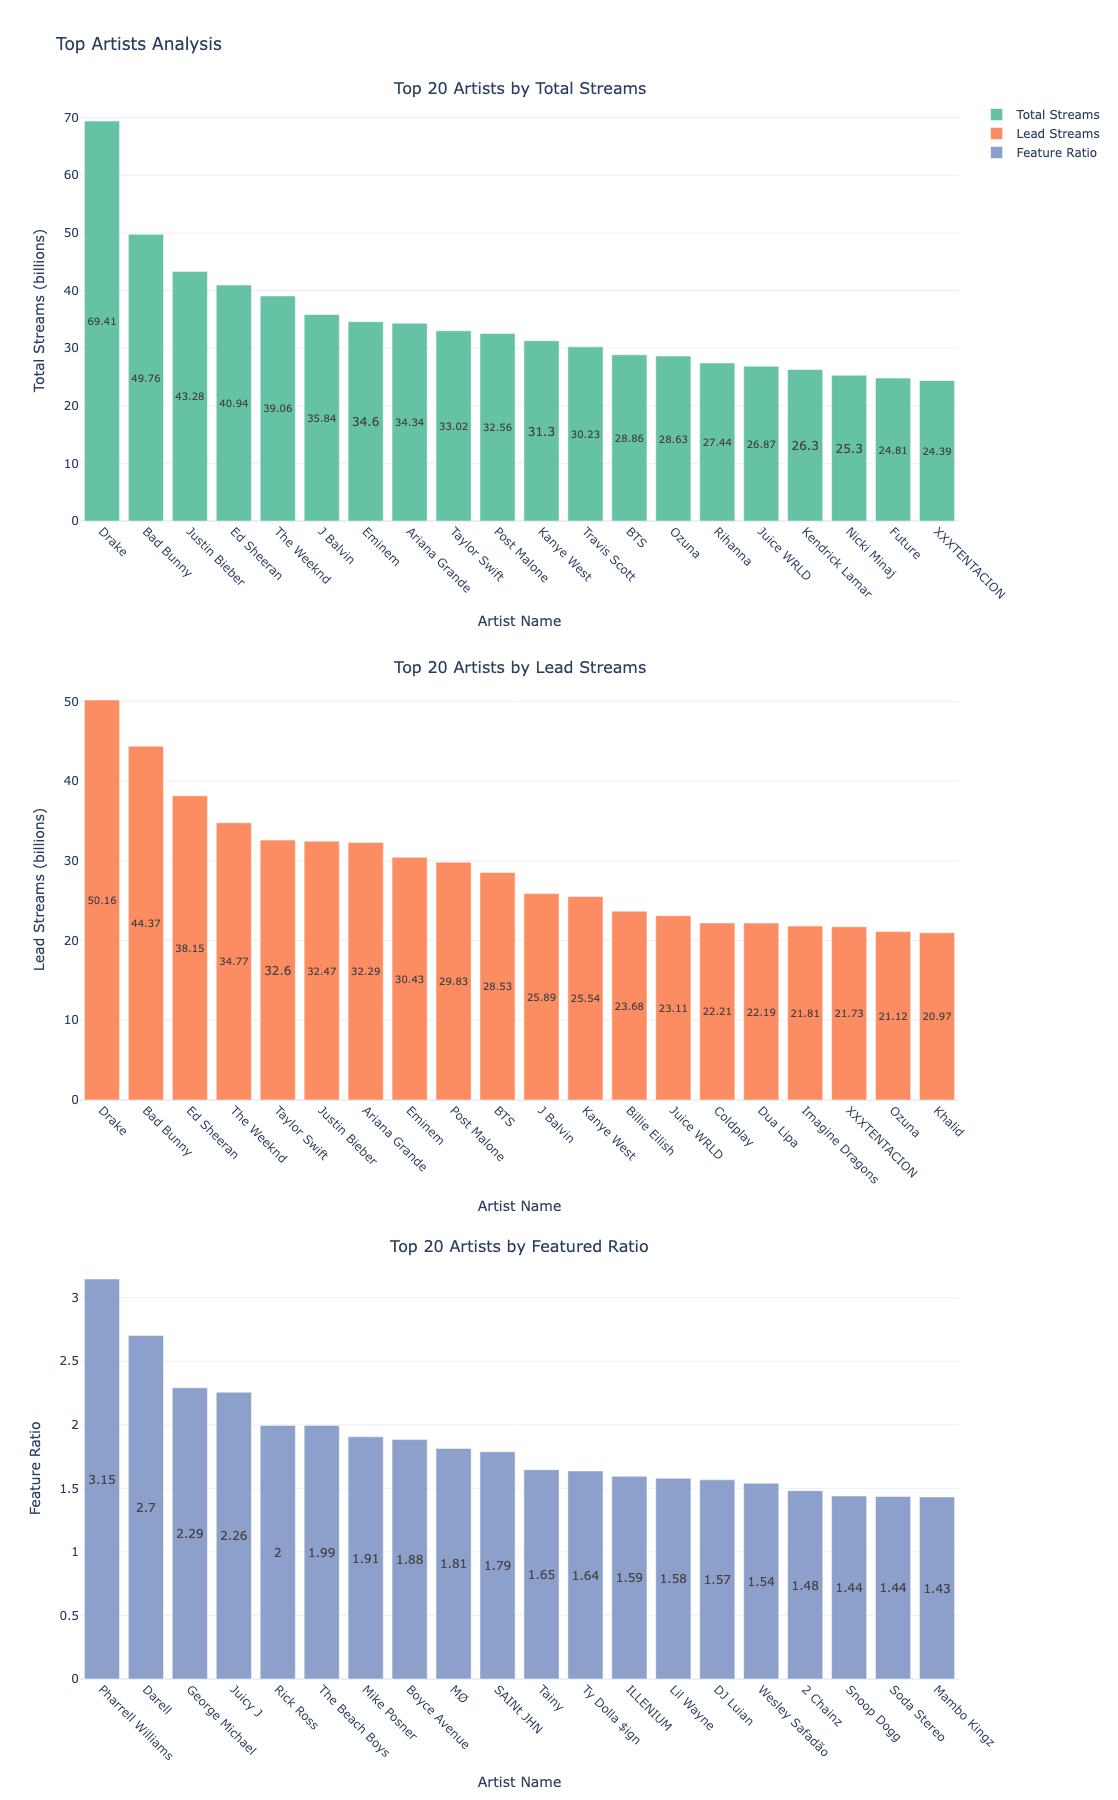

In [55]:
fig = make_subplots(rows=3, cols=1, subplot_titles=('Top 20 Artists by Total Streams',
                                                    'Top 20 Artists by Lead Streams',
                                                    'Top 20 Artists by Featured Ratio'),
                    vertical_spacing=0.1)

fig.add_trace(
    go.Bar(x=top_artists_total['artist_name'], y=top_artists_total['total_streams'] / 1e9,
           text=(top_artists_total['total_streams'] / 1e9).round(2), textposition='auto',
           name='Total Streams',
           textangle=0,
           hovertemplate='<b>Artist</b>: %{x}<br><b>Total Streams</b>: %{y:.2f} billion'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=top_artists_lead['artist_name'], y=top_artists_lead['lead_streams'] / 1e9,
           text=(top_artists_lead['lead_streams'] / 1e9).round(2), textposition='auto',
           name='Lead Streams',
           textangle=0,
           hovertemplate='<b>Artist</b>: %{x}<br><b>Lead Streams</b>: %{y:.2f} billion'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=top_featured_ratio['artist_name'], y=top_featured_ratio['feature_ratio'],
           text=top_featured_ratio['feature_ratio'].round(2), textposition='auto',
           name='Feature Ratio',
           textangle=0,
           hovertemplate='<b>Artist</b>: %{x}<br><b>Feature Ratio</b>: %{y:.2f}'),
    row=3, col=1
)

fig.update_layout(height=1800, width=1000, title_text='Top Artists Analysis')
fig.update_xaxes(tickangle=45, title_text='Artist Name')
fig.update_yaxes(title_text='Total Streams (billions)', row=1, col=1)
fig.update_yaxes(title_text='Lead Streams (billions)', row=2, col=1)
fig.update_yaxes(title_text='Feature Ratio', row=3, col=1)
fig.update_traces(textposition='inside', textangle=0, insidetextanchor='middle')

fig.show()

Percentage of artists with at least one billion-stream song: 19.61%


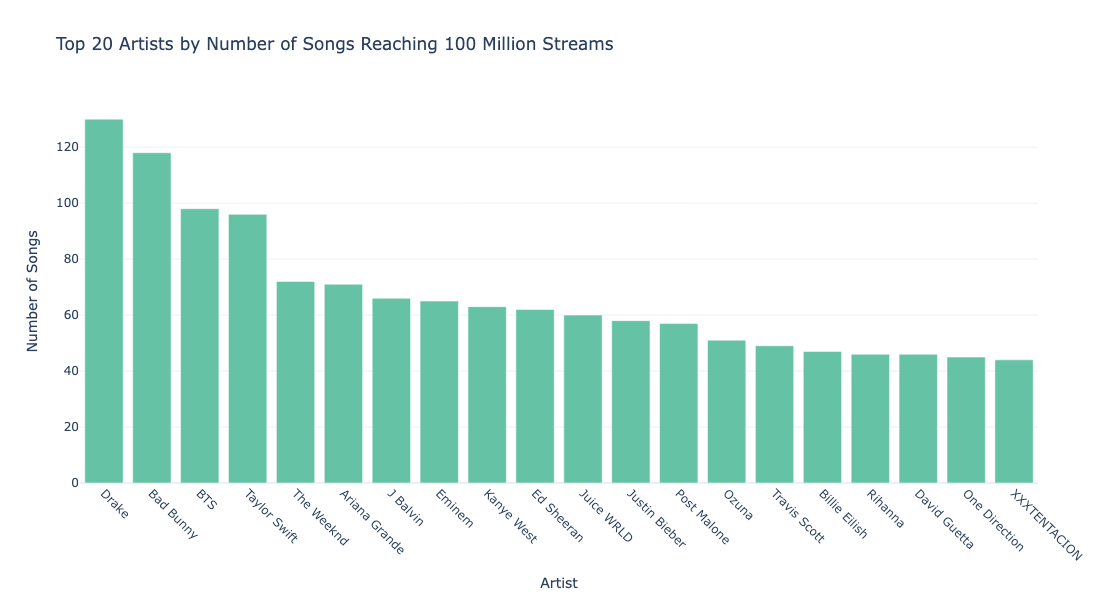

Correlation between total tracks and songs reaching 100 million streams**: 0.01</b>
Correlation between total tracks and songs reaching 1 billion streams: -0.05</b>


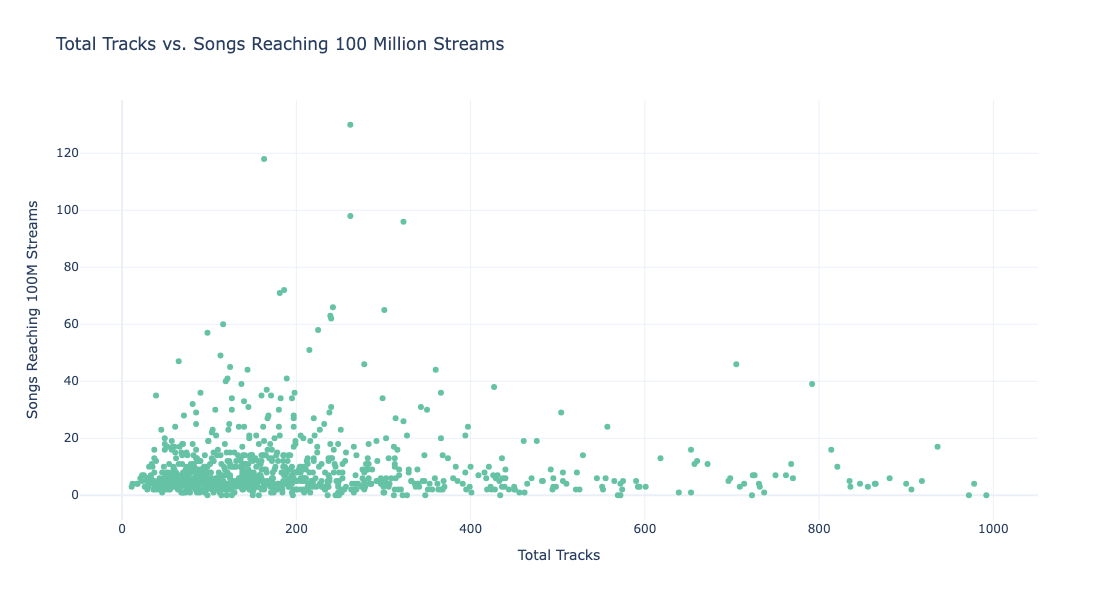

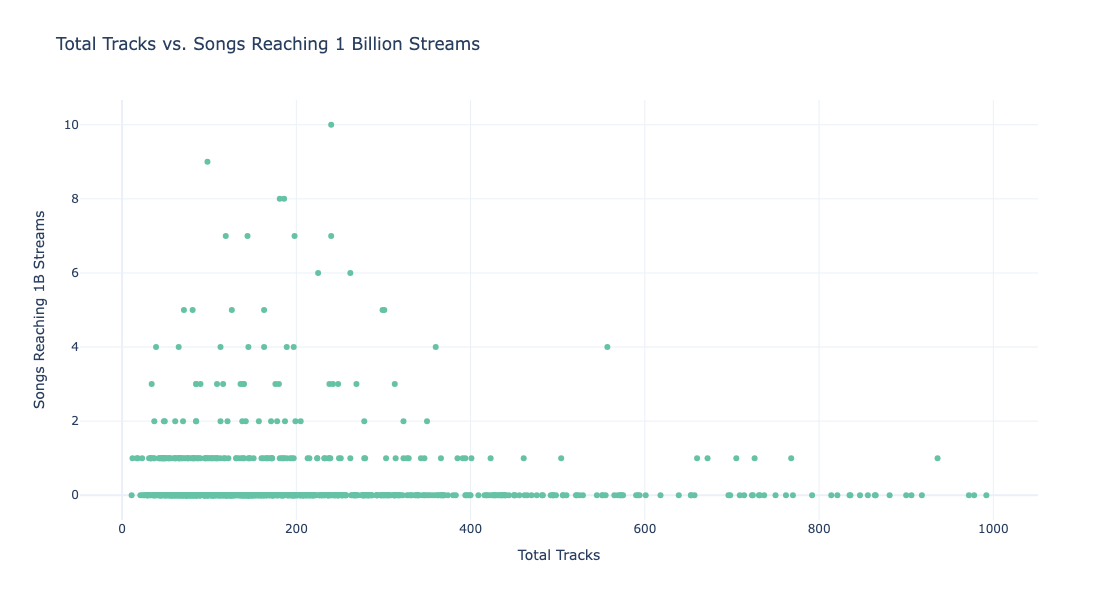

In [56]:
def milestone_achievements(df):
    # Removing artists who have more than 1000 songs
    df = df[df['tracks'] <= 1000]

    # Calculate the percentage of artists with at least one billion-stream song
    artists_with_billion = df[df['one_bil'] > 0]
    percentage_billion = (len(artists_with_billion) / len(df)) * 100

    print(f"Percentage of artists with at least one billion-stream song: {percentage_billion:.2f}%")

    # Find artists with the most songs reaching 100 million streams
    top_100mil_artists = df.nlargest(20, 'hund_mil')
    
    fig1 = px.bar(top_100mil_artists, x='artist_name', y='hund_mil', 
                  title='Top 20 Artists by Number of Songs Reaching 100 Million Streams',
                  labels={'artist_name': 'Artist', 'hund_mil': 'Number of Songs'})
    fig1.update_layout(xaxis_tickangle=45, height=600, width=1000)
    fig1.update_traces(hovertemplate='<b>Artist Name</b>: %{x}<br><b>Number of Songs</b>: %{y}')
    fig1.show()

    # Analyze the correlation between total tracks and number of songs reaching milestones
    correlation_100mil = df['tracks'].corr(df['hund_mil'])
    correlation_1bil = df['tracks'].corr(df['one_bil'])

    print(f"Correlation between total tracks and songs reaching 100 million streams**: {correlation_100mil:.2f}</b>")
    print(f"Correlation between total tracks and songs reaching 1 billion streams: {correlation_1bil:.2f}</b>")

    # Scatter plot for total tracks vs 100 million streams songs
    fig2 = px.scatter(df, x='tracks', y='hund_mil', 
                      title='Total Tracks vs. Songs Reaching 100 Million Streams',
                      labels={'tracks': 'Total Tracks', 'hund_mil': 'Songs Reaching 100M Streams'},
                      hover_data=['artist_name'])
    fig2.update_layout(height=600, width=1000)
    fig2.update_traces(hovertemplate='<b>Artist Name</b>: %{customdata[0]}<br><b>Total Tracks</b>: %{x}<br><b>Songs Reaching 100M</b>: %{y}')
    fig2.show()

    # Scatter plot for total tracks vs 1 billion streams songs
    fig3 = px.scatter(df, x='tracks', y='one_bil', 
                      title='Total Tracks vs. Songs Reaching 1 Billion Streams',
                      labels={'tracks': 'Total Tracks', 'one_bil': 'Songs Reaching 1B Streams'},
                      hover_data=['artist_name'])
    fig3.update_layout(height=600, width=1000)
    fig3.update_traces(hovertemplate='<b>Artist Name</b>: %{customdata[0]}<br><b>Total Tracks</b>: %{x}<br><b>Songs Reaching 1B</b>: %{y}')
    fig3.show()

# Call the function
milestone_achievements(spotify_artist)

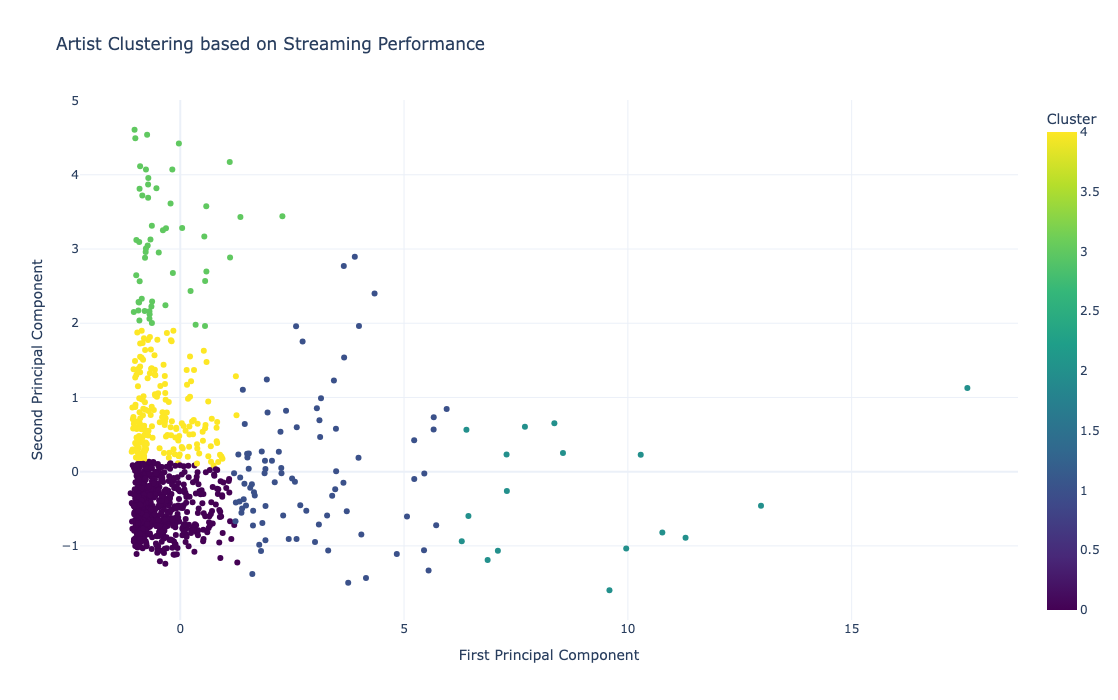

In [57]:
def cluster_artists(df, n_clusters=5):
    # Removing artists who have more than 1000 songs
    df = df[df['tracks'] <= 1000]
    
    # Select features for clustering
    features = ['lead_streams', 'feats', 'tracks', 'one_bil', 'hund_mil']
    
    # Prepare the data
    X = df[features]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_pca)
    
    # Add PCA components and cluster labels to the dataframe
    df_clustered = df.copy()
    df_clustered['PCA1'] = X_pca[:, 0]
    df_clustered['PCA2'] = X_pca[:, 1]
    df_clustered['Cluster'] = clusters
    
    # Create the scatter plot
    fig = px.scatter(df_clustered, x='PCA1', y='PCA2', color='Cluster',
                     hover_data=['artist_name'] + features,
                     labels={'PCA1': 'First Principal Component',
                             'PCA2': 'Second Principal Component'},
                     title='Artist Clustering based on Streaming Performance',
                     color_continuous_scale='Viridis')
    
    # Customize hover template
    hover_template = (
        "<b>Artist:</b> %{customdata[0]}<br>"
        "<b>Cluster:</b> %{marker.color}<br>"
        "<b>Lead Streams:</b> %{customdata[1]:,.0f}<br>"
        "<b>Featured Streams:</b> %{customdata[2]:,.0f}<br>"
        "<b>Tracks:</b> %{customdata[3]}<br>"
        "<b>1B+ Songs:</b> %{customdata[4]}<br>"
        "<b>100M+ Songs:</b> %{customdata[5]}"
    )
    fig.update_traces(hovertemplate=hover_template)
    
    # Update layout
    fig.update_layout(height=700, width=1000)
    
    # Show the plot
    fig.show()
    
    return df_clustered

# Call the function
clustered_df = cluster_artists(spotify_artist)